In [35]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from seaborn import heatmap
import matplotlib.pyplot as plt
from collections import OrderedDict
import os
import re
import operator
%matplotlib inline

In [13]:
good_aliases = pd.read_csv('aliases/goods.csv', header=None)
good_terms = good_aliases[0].tolist()

In [16]:
# Load data
df = pd.read_csv('csv/metadata_text_merged_cleaned.csv')
texts = df['text_cleaned_dealiased'].tolist()

In [17]:
# Create dictionary of dictionaries corresponding to pairs of items
item_pair_counts = {}

for good_name in good_terms:
    item_pair_counts[good_name] = {}
    
for key in item_pair_counts.keys():
    for good_name in good_terms:
        item_pair_counts[key][good_name] = 0

In [18]:
# Iterate over texts and fill in matrix
for text in tqdm_notebook(texts):
    # Boolean dict of dicts for explored pairs
    explored = {}
    
    for good_name in good_terms:
        explored[good_name] = {}
    
    for key in explored.keys():
        for good_name in good_terms:
            explored[key][good_name] = False
    
    
    for good1 in good_terms:
        for good2 in good_terms:
            if good1 != good2:
                if explored[good1][good2] is False and explored[good2][good1] is False and good1 in text and good2 in text:
                    # Update counts
                    item_pair_counts[good1][good2] += 1
                    item_pair_counts[good2][good1] += 1
                    
                    # Mark as explored
                    explored[good1][good2] = True
                    explored[good2][good1] = True

A Jupyter Widget

In [19]:
count_matrix = pd.DataFrame(item_pair_counts)

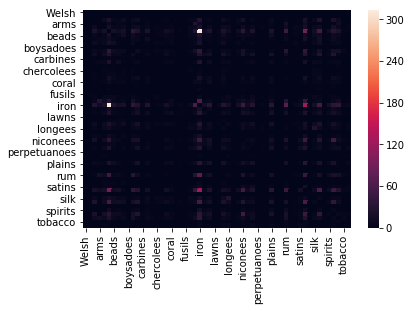

In [20]:
heatmap(count_matrix)

In [44]:
pair_freq = {}

for key1 in item_pair_counts:
    for key2 in item_pair_counts[key1]:
        if key1 != key2 and '{}-{}'.format(key2, key1) not in pair_freq.keys():
            pair_freq['{}-{}'.format(key1, key2)] = item_pair_counts[key1][key2]

In [46]:
sorted(pair_freq.items(), key=operator.itemgetter(1), reverse=True)[:25]

[('bars-iron', 313),
 ('says-iron', 126),
 ('bars-says', 94),
 ('rum-iron', 73),
 ('guns-iron', 63),
 ('says-sletias', 59),
 ('sletias-iron', 55),
 ('bars-sletias', 53),
 ('tapseils-niconees', 51),
 ('bars-rum', 50),
 ('says-niconees', 49),
 ('niconees-iron', 48),
 ('tapseils-says', 47),
 ('says-rum', 47),
 ('says-guns', 41),
 ('brandy-iron', 40),
 ('tapseils-sletias', 39),
 ('says-brandy', 39),
 ('times-iron', 39),
 ('bars-brandy', 37),
 ('bars-niconees', 36),
 ('tapseils-iron', 36),
 ('plains-iron', 34),
 ('says-plains', 33),
 ('knives-iron', 33)]